In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
from mpl_toolkits.axisartist import Subplot

In [2]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
import pandas as pd
import dill as pickle

from sbi.utils import ActiveSubspace
from pyloric import simulate, summary_stats

from stg_energy.common import svg
from stg_energy.fig3_amortize_energy.viz import (
    energy_scape,
    plot_eigenvalues,
    py_sensitivity_bars,
)
from stg_energy.fig4_sensitivity.helper_functions import (
    nth_argmax,
    nth_argmin,
    prepare_data,
    regression_plot,
)
import stg_energy.fig4_sensitivity.viz as viz

In [3]:
pd.options.display.max_columns=999

# Figure 4

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
PANEL_supp1 = "../svg/panel_supp1.svg"
PANEL_supp2 = "../svg/panel_supp2.svg"

PANEL_A0_NEW = "../svg/panel_a0_new.svg"
PANEL_A1_NEW = "../svg/panel_a1_new.svg"
PANEL_A2_NEW = "../svg/panel_a2_new.svg"
PANEL_B0_NEW = "../svg/panel_b0_new.svg"
PANEL_B1_NEW = "../svg/panel_b1_new.svg"
PANEL_B2_NEW = "../svg/panel_b2_new.svg"
PANEL_C_NEW = "../svg/panel_c_new.svg"
PANEL_C_angle = "../svg/panel_c_angle_illustration.svg"
PANEL_D1_NEW = "../svg/panel_d1_new.svg"
PANEL_D2_NEW = "../svg/panel_d2_new.svg"
PANEL_D3_NEW = "../svg/panel_d3_new.svg"
PANEL_D4_NEW = "../svg/panel_d4_new.svg"
PANEL_D5_NEW = "../svg/panel_d5_new.svg"
PANEL_D6_NEW = "../svg/panel_d6_new.svg"

PANEL_nn_reg_EperSpike = "../svg/panel_nn_reg_EperSpike.svg"
PANEL_nn_reg_numSpikes = "../svg/panel_nn_reg_numSpikes.svg"

### Sort out the data from the cluster

In [6]:
theta = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl")
x = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl")
seeds = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy")

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [7]:
with open('../../../results/trained_neural_nets/inference/posterior_11deg.pickle', 'rb') as handle:
    posterior = pickle.load(handle)

In [8]:
xo = np.load('../../../results/experimental_data/xo_11deg.npy')

# Train regression net

### Prepare parameters

In [84]:
num_test = 500

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

### Prepare energy/spike

In [85]:
all_energies_per_spike_ABPD = x['energies_per_spike']['PM'].to_numpy()
all_energies_per_spike_ABPD_test = torch.as_tensor(all_energies_per_spike_ABPD[:num_test], dtype=torch.float32).unsqueeze(1)
all_energies_per_spike_ABPD_train = torch.as_tensor(all_energies_per_spike_ABPD[num_test:], dtype=torch.float32).unsqueeze(1)

In [86]:
all_energies_per_spike_ABPD_train.shape

torch.Size([35439, 1])

In [87]:
numSpikesPerBurst = x['num_spikes']['PM'].to_numpy() / x['num_bursts']['PM'].to_numpy()
numSpikesPerBurst_test = torch.as_tensor(numSpikesPerBurst[:num_test], dtype=torch.float32).unsqueeze(1)
numSpikesPerBurst_train = torch.as_tensor(numSpikesPerBurst[num_test:], dtype=torch.float32).unsqueeze(1)

### Train classifier for energy per spike

In [88]:
sensitivity = ActiveSubspace(posterior.set_default_x(xo))

In [89]:
converged_nn = sensitivity.add_property(
    theta_train,
    all_energies_per_spike_ABPD_train,
    hidden_features=20,
    num_blocks=1
).train(max_num_epochs=2)

In [90]:
predictions = converged_nn(theta_test).detach().numpy()

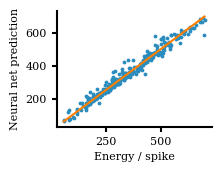

In [91]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = all_energies_per_spike_ABPD_test[:300].numpy()
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp1, facecolor="None", transparent=True)

### Regression network for #spikes

### Get active subspace for E / spike

In [92]:
e_vals, e_vecs = sensitivity.find_active()

Ratio of first to second eigenvalue:  tensor(307.0017)


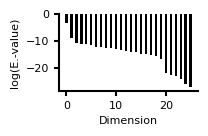

In [93]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals, dims=(0,))),
        figsize=(1.8, 1.0),
        ylabel="log(E.-value)",
        color='k'
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals[-1] / e_vals[-2],
    )
    plt.savefig(PANEL_A0_NEW, facecolor="None", transparent=True)
    plt.show()

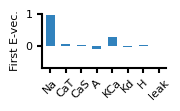

In [94]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs[0:8, -1:].T,
        ylim=[-0.7, 1.0],
        figsize=(1.6, 0.7),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_A1_NEW, facecolor="None", transparent=True)
    plt.show()

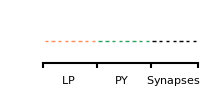

In [95]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs[8:, -1:].T, ylim=[-0.7, 1.0], figsize=(2.0, 0.7)
    )
    plt.savefig(PANEL_A2_NEW, facecolor="None", transparent=True)
    plt.show()

### Get active subspace for number of spikes

In [96]:
sensitivity_num_spikes = ActiveSubspace(posterior.set_default_x(xo))

In [97]:
converged_nn_num_spikes = sensitivity_num_spikes.add_property(
    theta_train,
    numSpikesPerBurst_train,
    hidden_features=20,
    num_blocks=1
).train(max_num_epochs=2)

In [98]:
predictions = converged_nn_num_spikes(theta_test).detach().numpy()

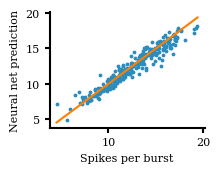

In [99]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = numSpikesPerBurst_test[:300].numpy()
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp2, facecolor="None", transparent=True)

In [100]:
e_vals_num_spikes, e_vecs_num_spikes = sensitivity_num_spikes.find_active()

Ratio of first to second eigenvalue:  tensor(55.9759)


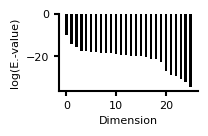

In [101]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals_num_spikes, dims=(0,))),
        figsize=(1.8, 1.0),
        ylabel="log(E.-value)",
        color='k'
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_num_spikes[-1] / e_vals_num_spikes[-2],
    )
    plt.savefig(PANEL_B0_NEW, facecolor="None", transparent=True)
    plt.show()

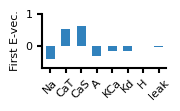

In [102]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs_num_spikes[0:8, -1:].T,
        ylim=[-0.7, 1.0],
        figsize=(1.6, 0.7),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_B1_NEW, facecolor="None", transparent=True)
    plt.show()

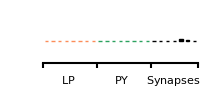

In [103]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs_num_spikes[8:, -1:].T, ylim=[-0.7, 1.0], figsize=(2.0, 0.7)
    )
    plt.savefig(PANEL_B2_NEW, facecolor="None", transparent=True)
    plt.show()

In [104]:
v1 = e_vecs_num_spikes[:, -1]
v2 = e_vecs[:, -1]

In [105]:
norm_v1 = torch.norm(v1)
print(v2)

tensor([ 9.5302e-01,  6.1007e-02,  3.3579e-02, -9.3122e-02,  2.7588e-01,
        -3.5913e-02,  7.0745e-03, -2.2624e-03,  6.6320e-03,  3.2385e-04,
        -1.6065e-04,  3.3435e-03,  3.9594e-03, -6.5005e-03, -1.8813e-03,
         7.5386e-03, -5.4543e-03,  1.3298e-02, -1.6737e-03,  4.5605e-03,
         2.5183e-03,  7.1121e-03,  4.1047e-03, -4.0366e-03,  1.2437e-02,
        -1.4762e-03, -4.2061e-03, -4.2581e-03,  6.2489e-03,  6.8568e-03,
         1.1894e-03])


In [106]:
dot_prod = torch.dot(v1, v2).item()
print('dot_prod', dot_prod)

dot_prod -0.3497956097126007


In [107]:
import math
angle = math.acos(dot_prod)
print('angle in rad:', angle)
print('angle in deg:', angle / 2 / math.pi * 360)

angle in rad: 1.928149248402582
angle in deg: 110.47481420478972


# Project parameters into plane

In [110]:
projected_e_per_spike = sensitivity.project(theta_train, num_dimensions=1)
projected_num_spikes = sensitivity_num_spikes.project(theta_train, num_dimensions=1)

### Select three interesting parameter sets

In [120]:
ind_of_min_e_per_spike = nth_argmin(projected_e_per_spike, 0)
ind_of_max_e_per_spike = nth_argmax(projected_e_per_spike, 27)

In [121]:
ind_of_min_numSpikes = nth_argmin(projected_num_spikes, 14)
ind_of_max_numSpikes = nth_argmax(projected_num_spikes, 0)

In [122]:
cond1 = projected_e_per_spike > -1.2
cond2 = projected_e_per_spike < -0.8
cond3 = projected_num_spikes > -1.2
cond4 = projected_num_spikes < -0.8

In [123]:
full_cond = torch.logical_and(torch.logical_and(torch.logical_and(cond1, cond2), cond3), cond4)

In [133]:
fulfiling_param_sets = theta_train[full_cond[:, 0]]
print(fulfiling_param_sets.shape)

In [126]:
parameter_set1 = theta_train[ind_of_min_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = sensitivity.project(parameter_set1, num_dimensions=1)
parameter_set1_dim2 = sensitivity_num_spikes.project(parameter_set1, num_dimensions=1)

parameter_set2 = theta_train[ind_of_min_numSpikes].unsqueeze(0)
parameter_set2_dim1 = sensitivity.project(parameter_set2, num_dimensions=1)
parameter_set2_dim2 = sensitivity_num_spikes.project(parameter_set2, num_dimensions=1)

# parameter_set3 = train_params_norm[ind_of_max_e_per_spike].unsqueeze(0)
parameter_set3 = theta_train[full_cond[:, 0]][0].unsqueeze(0)
parameter_set3_dim1 = sensitivity.project(parameter_set3, num_dimensions=1)
parameter_set3_dim2 = sensitivity_num_spikes.project(parameter_set3, num_dimensions=1)

### For coloring the dots with the energy consumed by the AB/PD neuron, load the energies

In [128]:
energies = x['energies']['PM'].to_numpy()
energies_train = energies[500:]

# Panel E

### Non-orthogonal version

In [129]:
angle_within_90deg = math.pi - angle

In [130]:
from matplotlib import ticker
my_ticker = ticker.FixedFormatter([-2,0,2])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

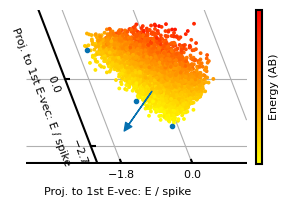

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from  mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
from mpl_toolkits.axisartist import Subplot, ParasiteAxesAuxTrans
import  mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import FixedLocator

def curvelinear_test1(fig):
    xlims = [-3.4, 2.2]
    ylims = [-3.42, 2.8]

    # We need this ration because the scale on the y-axis and on the x-axis is
    # different. The ration is approximately 2.7 / 1.8, which is the ratio of
    # the mins of the data in the respective dimensions. Correctness of the
    # ration 1.55 was checked by manually rotating the ylabel with:
    # `ax1.axis["y"].label.set_rotation(-19)`. 19 degree is the true angle from
    # a right angle.
    ratio_yx = 1.55

    def tr(x, y):
        x, y = np.asarray(x), np.asarray(y)
        return x-y / math.tan(angle_within_90deg) / ratio_yx, y
    def inv_tr(x,y):
        x, y = np.asarray(x), np.asarray(y)
        return x + y * math.tan(angle_within_90deg) * ratio_yx, y

    grid_locator1 = FixedLocator([-1.8, 0, 1.8])
    grid_locator2 = FixedLocator([-2.7, 0])

    grid_helper = GridHelperCurveLinear(aux_trans=(tr, inv_tr), 
                                        grid_locator1=grid_locator1,
                                        grid_locator2=grid_locator2)
    
    ax1 = Subplot(fig, 1, 1, 1, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
#     ax1.grid(zorder=-100)
    ax1.grid(True, which='minor', zorder=-100)
    
    projected_data_x, projected_data_y = tr(projected_num_spikes[:4000].T, projected_e_per_spike[:4000].T)
    im = ax1.scatter(
        projected_data_x,
        projected_data_y,
        s=3,
        c=energies_train[:4000],
        cmap='autumn_r'
    )
    ax1.scatter(*tr(parameter_set1_dim2, parameter_set1_dim1), color="#0570b0")
    ax1.scatter(*tr(parameter_set2_dim2, parameter_set2_dim1), color="#0570b0")
    ax1.scatter(*tr(parameter_set3_dim2, parameter_set3_dim1), color="#0570b0")
    
    ax1.annotate(
        "",
        xy=(-0.9, -2.1),
        xytext=(-0.2, -0.5),
        arrowprops=dict(
            facecolor="#0570b0",
            edgecolor="#0570b0",
            headwidth=5.4,
            headlength=5.7,
            width=0.1,
        ),
    )
    
    ax1.axis["right"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["left"].set_visible(False)

    xx, yy = tr([3, 6], [5.0, 10.])
    ax1.plot(xx, yy)

    ax1.set_xlim(xlims)
    ax1.set_ylim(ylims)
    
    ax1.set_ylabel("Proj. to 1st E-vec: E / spike")
    ax1.set_xlabel("Proj. to 1st E-vec: E / spike")
    
    ax1.axis["y"]=ax1.new_floating_axis(0, -2.4)
    ax1.axis["x"]=ax1.new_floating_axis(1, -3.4)
    ax1.axis["y"].set_axis_direction("top")
    ax1.axis["y"].label.set_axis_direction("bottom")
    ax1.axis["y"].set_ticklabel_direction("+")
    ax1.axis["y"].invert_ticklabel_direction()
    
    cbar = plt.colorbar(im, aspect=25, fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label("Energy (AB)", labelpad=5)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig = plt.figure(figsize=(3.1, 2.0))
    curvelinear_test1(fig)
    plt.savefig(PANEL_C_NEW, facecolor="None", transparent=True)
    plt.show()

In [137]:
all_energies_per_spike = x['energies_per_spike']['PM'].to_numpy()
all_energies = x['energies']['PM'].to_numpy()
all_num_spikes = x['num_spikes']['PM'].to_numpy()

min_energy_per_spike = np.min(all_energies_per_spike)
max_energy_per_spike = np.max(all_energies_per_spike)

min_energy = np.min(all_energies)
max_energy = np.max(all_energies)

min_num_spikes = np.min(all_num_spikes)
max_num_spikes = np.max(all_num_spikes)

In [146]:
unnorm_set_dim_1 = pd.DataFrame(parameter_set1[:1], columns=theta.columns)
unnorm_set_dim_2 = pd.DataFrame(parameter_set2[:1], columns=theta.columns)
unnorm_set_dim_3 = pd.DataFrame(parameter_set3[:1], columns=theta.columns)

simulation_output_1 = simulate(unnorm_set_dim_1.loc[0], seed=0, track_energy=True, track_currents=True)
simulation_output_2 = simulate(unnorm_set_dim_2.loc[0], seed=0, track_energy=True, track_currents=True)
simulation_output_3 = simulate(unnorm_set_dim_3.loc[0], seed=0, track_energy=True, track_currents=True)

In [147]:
time_vec = np.arange(0, 11000, 0.025)

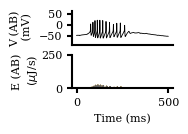

In [153]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    energy_scape(
        simulation_output_1,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=106000,
        ylimE=[0, 250],
        v_labelpad=4.7,
        neuron=0,
    )
#     plt.savefig(PANEL_D1_NEW, facecolor="None", transparent=True)

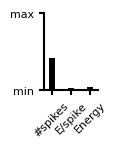

In [163]:
summstats = summary_stats(
    simulation_output_1,
    stats_customization={
        'energies': True,
        'num_spikes': True,
        'energies_per_spike': True
    }
)
num_spikes_ABPD = summstats['num_spikes']['PM'].to_numpy()[0]
energies_ABPD_sim = summstats['energies']['PM'].to_numpy()[0]
energyperspike_ABPD_sim = summstats['energies_per_spike']['PM'].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
        facecolor='k',
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D2_NEW, facecolor="None", transparent=True)
    plt.show()

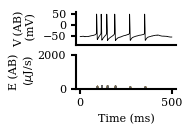

In [166]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    energy_scape(
        simulation_output_2,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=305000,
        ylimE=[0, 2000],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_D3_NEW, facecolor="None", transparent=True)

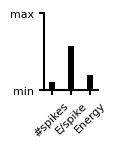

In [169]:
summstats = summary_stats(
    simulation_output_2,
    stats_customization={
        'energies': True,
        'num_spikes': True,
        'energies_per_spike': True
    }
)
num_spikes_ABPD = summstats['num_spikes']['PM'].to_numpy()[0]
energies_ABPD_sim = summstats['energies']['PM'].to_numpy()[0]
energyperspike_ABPD_sim = summstats['energies_per_spike']['PM'].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
        facecolor='k',
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D4_NEW, facecolor="None", transparent=True)
    plt.show()

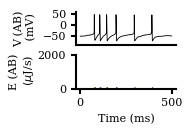

In [171]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    energy_scape(
        simulation_output_3,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=118000,
        ylimE=[0, 2000],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_D5_NEW, facecolor="None", transparent=True)

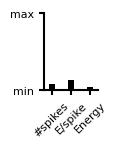

In [173]:
summstats = summary_stats(
    simulation_output_3,
    stats_customization={
        'energies': True,
        'num_spikes': True,
        'energies_per_spike': True
    }
)
num_spikes_ABPD = summstats['num_spikes']['PM'].to_numpy()[0]
energies_ABPD_sim = summstats['energies']['PM'].to_numpy()[0]
energyperspike_ABPD_sim = summstats['energies_per_spike']['PM'].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
        facecolor='k',
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D6_NEW, facecolor="None", transparent=True)
    plt.show()

# Assemble figure

Todos after the figure:
- #spikes -> E/spike on y-axis
- grid has to be truncated
- "minimal energy" a bit closer together 
- axis truncated

In [174]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [177]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'color': '#0570b0'}

f = Figure("20.3cm", "9.1cm",

    Panel(
         SVG(PANEL_nn_reg_EperSpike).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -3.2*factor_svg, -0.5*factor_svg, **kwargs_text),
    ).move(3.2*factor_svg, 3.0*factor_svg),
    
    Panel(
         SVG(PANEL_A1_NEW).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(34.5*factor_svg, 0.0*factor_svg),
    
    Panel(
         SVG(PANEL_A2_NEW).scale(svg_scale).move(0, 0*factor_svg),
    ).move(56.5*factor_svg, 0.6*factor_svg),

    Panel(
        SVG(PANEL_nn_reg_numSpikes).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("c", -3.2*factor_svg, -0.5*factor_svg, **kwargs_text),
    ).move(3.2*factor_svg, 22*factor_svg),
    
    Panel(
        SVG(PANEL_B1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("d", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(34.5*factor_svg, 19.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(56.5*factor_svg, 19.6*factor_svg),
    
    Panel(
          SVG(PANEL_C_NEW).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("e", 0.5*factor_svg, 0.5*factor_svg, **kwargs_text),
        Text("g", 11.6*factor_svg, 10.9*factor_svg, **kwargs_text8pt_red),
        Text("h", 19.2*factor_svg, 17.6*factor_svg, **kwargs_text8pt_red),
        Text("f", 27.5*factor_svg, 26.3*factor_svg, **kwargs_text8pt_red),
        Text("minimal", 15.5*factor_svg, 23.6*factor_svg, **kwargs_text8pt_red),
        Text("energy", 15.5*factor_svg, 25.6*factor_svg, **kwargs_text8pt_red),
    ).move(94*factor_svg, 2*factor_svg),
           
    Panel(
        SVG(PANEL_C_angle).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(97*factor_svg, 28.6*factor_svg),

    Panel(
          SVG(PANEL_D1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("f", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 40.0*factor_svg),

    Panel(
          SVG(PANEL_D2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(29*factor_svg, 39.5*factor_svg),

    Panel(
          SVG(PANEL_D3_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(48*factor_svg, 40*factor_svg),

    Panel(
          SVG(PANEL_D4_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(75*factor_svg, 39.5*factor_svg),

    Panel(
          SVG(PANEL_D5_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("h", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(94*factor_svg, 40*factor_svg),

    Panel(
          SVG(PANEL_D6_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(121*factor_svg, 39.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig4_new.svg")
svg('../fig/fig4_new.svg')

### Assemble supplementary

In [178]:
f = Figure("20.3cm", "3.0cm",

    Panel(
         SVG(PANEL_A0_NEW).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_B0_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(50*factor_svg, 0.0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4_supp_EV_spectrum.svg")
svg('../fig/fig4_supp_EV_spectrum.svg')

In [179]:
f = Figure("20.3cm", "3.9cm",

    Panel(
         SVG(PANEL_supp1).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_supp2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(50*factor_svg, 0.0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4_supp_convergence.svg")
svg('../fig/fig4_supp_convergence.svg')